In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix

21944
C:\Users\novikau1\Documents\work\codes\QuCF\scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# ---------------------------------------------------------------------------------------------------
nx, nt = 3, 9
Nx = 1<<nx
Nt = 1<<nt
x = np.linspace(-2,2,Nx)
t = np.linspace(0,4,Nt)
dx = np.diff(x)[0]
dt = np.diff(t)[0]

psi_tx = np.zeros((Nt,Nx), dtype = float)

delta_gauss = 0.05
x_center = 1.0
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_tx[0, ii] = np.exp(-(x[ii] - x_center)**2/(2.*delta_gauss**2))
psi_tx[0, :] = np.sqrt(coef_gauss * psi_tx[0, :])
print("sum psi**2: {:0.3e}".format(np.trapz(psi_tx[0, :]**2, dx=dx)))

# wavefunctino(time,space): 
psi_tx[0,0] = 0
psi_tx[0,Nx-1] = 0

del ii

sum psi**2: 7.696e-02


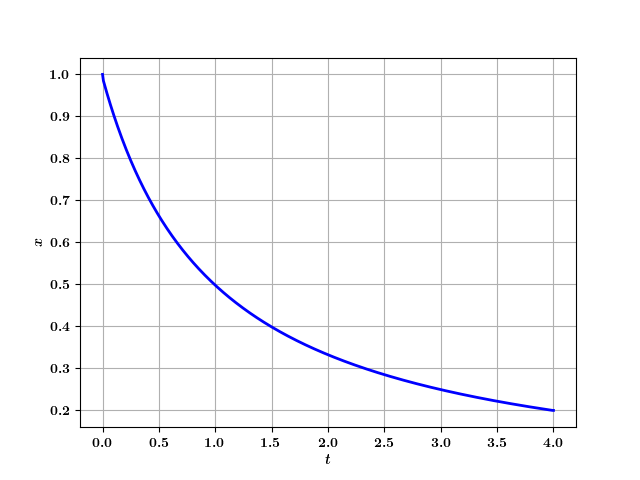

In [4]:
# -----------------------------------------------------------------
# --- Solve d x / d t = - x**2: standart method (for reference) ---
# -----------------------------------------------------------------
from scipy.integrate import RK45
mix.reload_module(mix)

oo = RK45(
    lambda t,x: -x**2, 
    t[0], 
    [x_center], t[-1], first_step=dt, max_step=dt
)

x_direct = np.zeros(Nt, dtype=float)
x_direct[0] = x_center
Nt_act = 1

oo.step()
oo.t

while mix.compare_two_strings(oo.status, "running"):
    oo.step()
    Nt_act += 1
    if Nt_act - 1 == Nt:
        print(oo.t)
    x_direct[Nt_act-1]   = float(oo.y[0])
    
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, x_direct, color='b', linewidth = 2, linestyle='-')
plt.xlabel('$t$')
plt.ylabel("$x$")
plt.grid(True)
plt.show()

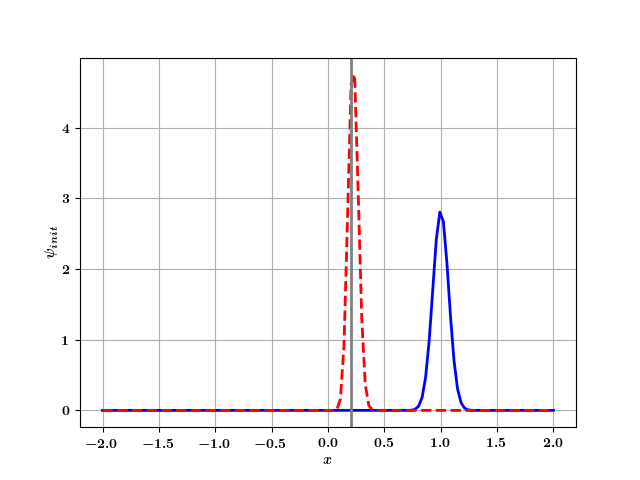

(0.0, 1.5)

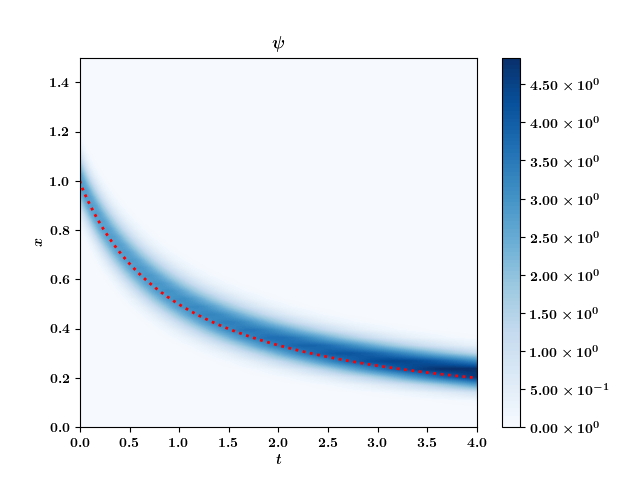

In [5]:
# --------------------------------------------------------
# --- Solve the equation using Liouville equation ---
# --------------------------------------------------------
for it in range(Nt-1):
    for ix in range(1,Nx-1):
        x1 = x[ix]
        x2h = x1**2/dx

        # ix+1 is taken (upwinding)
        psi_tx[it+1,ix] = psi_tx[it,ix] + dt * (2*x1*psi_tx[it,ix] + x2h * (psi_tx[it,ix+1] - psi_tx[it,ix]) ) 

psi_tx_transposed = np.transpose(psi_tx)

del it, ix

# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
plt.close()
plt.close()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi_tx[0,:], color='b', linewidth = 2, linestyle='-')
ax.plot(x, psi_tx[-1,:], color='r', linewidth = 2, linestyle='--')
# ax.vlines(x_direct[-1], ax.get_ylim()[0]-1, ax.get_ylim()[1]+1)
ax.axvline(x_direct[-1], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'gray', linewidth = 2, linestyle = "-")
plt.xlabel('$x$')
plt.ylabel("$\psi_{init}$")
# ax.legend()
plt.grid(True)
plt.show()

# ---------------------------------------------------------------------------------------------------
# --- Print psi(t,x) ---
# ---------------------------------------------------------------------------------------------------
XX, YY = np.meshgrid(t, x)

# plt.close()
fig_tx = plt.figure()
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, psi_tx_transposed, levels=100, cmap=cmap_two_signs_)
fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.plot(t, x_direct, color='r', linewidth = 2, linestyle=':')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$\psi$')
ax.set_ylim(0.0, 1.5)

In [15]:
# -----------------------------------------------------------------------------------------------------
# --- Construct and analyse the Liouville matrix ---
# * an eigenvalue is degenerate if there are several eigenvectors that correspond to this eigenvalue
# -----------------------------------------------------------------------------------------------------
from scipy.linalg import eig

# -----------------------------------------------------------------------------------------------------
# --- Construct and analyse the KvN matrix ---
# -----------------------------------------------------------------------------------------------------
# *** upwinding ***
A_uw_KvN = np.zeros((Nx, Nx), dtype=complex)

for ii in range(1,Nx-1):
    x1 = x[ii]
    diff_x = x1*x1/dx
    A_uw_KvN[ii,ii]   = x1 - diff_x
    A_uw_KvN[ii,ii+1] = diff_x
A_uw_KvN = 1j * A_uw_KvN
A_uw_KvN[0,0] = 1.0
A_uw_KvN[Nx-1, Nx-1] = 1.0
eig_values_uw_KvN, eig_vectors_uw_KvN = eig(A_uw_KvN)
del ii

# # *** central finite difference ***
# A_cd_KvN = np.zeros((Nx, Nx), dtype=complex)
# for ii in range(1,Nx-1):
#     x1 = x[ii]
#     diff_x = x1*x1/(2.*dx)
#     A_cd_KvN[ii,ii-1] = - diff_x
#     A_cd_KvN[ii,ii]   = x1
#     A_cd_KvN[ii,ii+1] = diff_x
# A_cd_KvN = 1j * A_cd_KvN
# A_cd_KvN[0,0] = 1.0
# A_cd_KvN[Nx-1, Nx-1] = 1.0
# eig_values_cd_KvN, eig_vectors_cd_KvN = eig(A_cd_KvN)
# del ii


# *** central finite difference ***
A_cd_KvN = np.zeros((Nx, Nx), dtype=complex)
for ii in range(1,Nx-1):
    x1 = x[ii]
    diff_x_p = x[ii+1]**2/(2.*dx)
    diff_x_m = x[ii]**2/(2.*dx)
    A_cd_KvN[ii,ii-1] = - diff_x_m
    A_cd_KvN[ii,ii]   = 0
    A_cd_KvN[ii,ii+1] = diff_x_p
    if ii == 1:
        A_cd_KvN[ii,ii-1] = 0.
    if ii == (Nx-2):
        A_cd_KvN[ii,ii+1] = 0
A_cd_KvN = 1j * A_cd_KvN
A_cd_KvN[0,0] = 1.0
A_cd_KvN[Nx-1, Nx-1] = 1.0
eig_values_cd_KvN, eig_vectors_cd_KvN = eig(A_cd_KvN)
del ii

In [16]:
mix.print_matrix(A_cd_KvN)

--- 0 ---
 1.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j
--- 1 ---
 0.000+0.000j  0.000+0.000j  0.000+0.643j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j
--- 2 ---
 0.000+0.000j -0.000-0.643j  0.000+0.000j  0.000+0.071j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j
--- 3 ---
 0.000+0.000j  0.000+0.000j -0.000-0.071j  0.000+0.000j  0.000+0.071j  0.000+0.000j  0.000+0.000j  0.000+0.000j
--- 4 ---
 0.000+0.000j  0.000+0.000j  0.000+0.000j -0.000-0.071j  0.000+0.000j  0.000+0.643j  0.000+0.000j  0.000+0.000j
--- 5 ---
 0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j -0.000-0.643j  0.000+0.000j  0.000+1.786j  0.000+0.000j
--- 6 ---
 0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j -0.000-1.786j  0.000+0.000j  0.000+0.000j
--- 7 ---
 0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  0.000+0.000j  1.000+0.000j


In [17]:
eig_values_cd_KvN

array([-1.898+0.j,  1.898+0.j,  0.067+0.j, -0.067+0.j,  0.647+0.j,
       -0.647+0.j,  1.   +0.j,  1.   +0.j])

In [18]:
# np.transpose(np.conjugate(
#     np.array([
#         [1, 1j],
#         [2j, 2+3j]
#     ])
# ))

# A_Ha = np.transpose(np.conjugate(A_uw_KvN))
# A_Ha.dot(A_uw_KvN)

A_Ha = np.transpose(np.conjugate(A_cd_KvN))
mix.print_matrix(A_Ha - A_cd_KvN)

--- 0 ---
 0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j
--- 1 ---
 0.000-0.000j  0.000-0.000j -0.000+0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j
--- 2 ---
 0.000-0.000j  0.000+0.000j  0.000-0.000j -0.000+0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j
--- 3 ---
 0.000-0.000j  0.000-0.000j  0.000+0.000j  0.000-0.000j -0.000+0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j
--- 4 ---
 0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000+0.000j  0.000-0.000j -0.000+0.000j  0.000-0.000j  0.000-0.000j
--- 5 ---
 0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000+0.000j  0.000-0.000j -0.000+0.000j  0.000-0.000j
--- 6 ---
 0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000+0.000j  0.000-0.000j  0.000-0.000j
--- 7 ---
 0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j  0.000-0.000j


In [10]:
print("{:20.19e}".format(eig_values_uw_KvN[5]))
print("{:20.19e}".format(eig_values_uw_KvN[123]))

-0.0000000000000000000e+00-1.0962992125984270331e+02j
-0.0000000000000000000e+00-1.0962992125984270331e+02j


In [8]:
# --------------------------------------------------------------
# --- find multiplicity of different eigenvalues ---
# --------------------------------------------------------------
def find_equal_eigenvalues(eigvs):
    equal_values = []
    for ii in range(Nx-1):
        v1 = eigvs[ii]
        temp = None
        for kk in range(ii+1, Nx):
            if mix.compare_complex_values(v1, eigvs[kk], prec = 1e-15):
                if temp is None:
                    temp = [v1, 2, [ii, kk]]
                else:
                    temp[1] += 1
                    temp[2].append(kk)
        if temp is not None:
            equal_values.append(temp)
    return equal_values

print("--- KvN: upwinding scheme ---")
print(find_equal_eigenvalues(eig_values_uw_KvN))
print()

--- KvN: upwinding scheme ---
[[1j, 2, [0, 127]], [(-0-109.6299212598427j), 2, [5, 123]], [(-0-105.94488188976395j), 2, [6, 122]], [(-0-102.32283464566946j), 2, [7, 121]], [(-0-95.26771653543324j), 2, [9, 119]], [(-0-91.83464566929152j), 2, [10, 118]], [(-0-66.63779527559068j), 2, [18, 110]], [(-0-55.55118110236229j), 2, [22, 106]], [(-0-50.38582677165363j), 2, [24, 104]], [(-0-47.89763779527568j), 2, [25, 103]], [(-0-32.244094488189035j), 2, [32, 96]], [(-0-30.259842519685094j), 2, [33, 95]], [(-0-28.338582677165412j), 2, [34, 94]], [(-0-19.67716535433074j), 2, [39, 89]], [(-0-10.1968503937008j), 2, [46, 82]], [(-0-9.094488188976392j), 2, [47, 81]], [(-0-7.078740157480329j), 2, [49, 79]], [(-0-6.165354330708675j), 2, [50, 78]], [(-0-3.1417322834645702j), 2, [54, 74]], [(-0-2.5433070866141767j), 2, [55, 73]], [(-0-2.007874015748035j), 2, [56, 72]], [(-0-1.5354330708661452j), 2, [57, 71]], [(-0-1.1259842519685073j), 2, [58, 70]], [(-0-0.11811023622047223j), 2, [62, 66]], [(-0-0.02362204

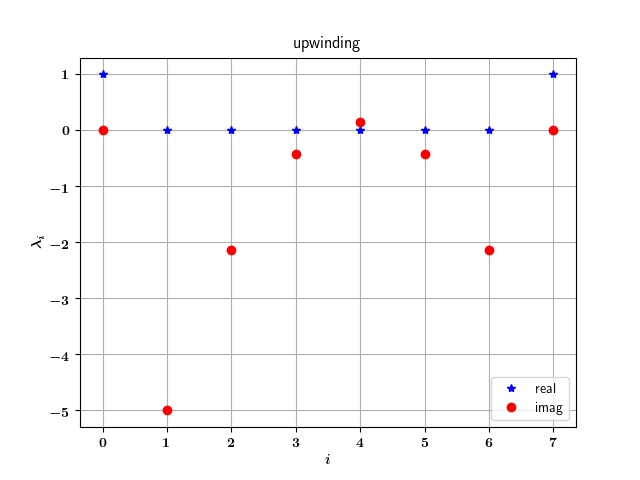

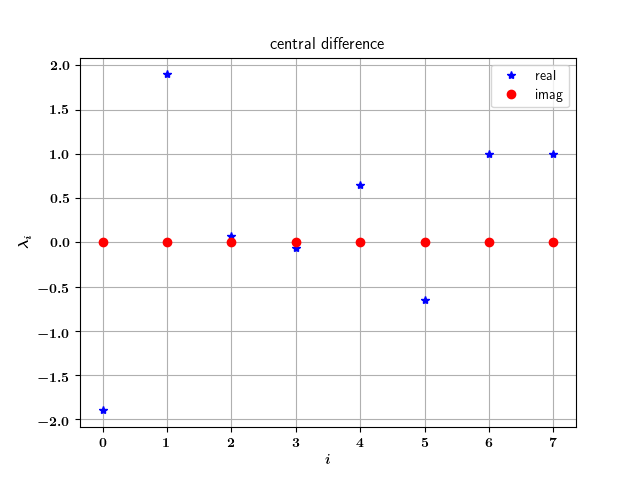

In [19]:
# -----------------------------------------
# --- Plot eigenvalues and eigenvectors ---
# -----------------------------------------
plt.close()
plt.close()
plt.close()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(range(Nx)), eig_values_uw_KvN.real, "*b",label="real")
ax.plot(np.array(range(Nx)), eig_values_uw_KvN.imag, "or",label="imag")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.title("upwinding")
ax.legend()
plt.grid(True)
plt.show()


# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(np.array(range(Nx)), eig_vectors_uw[58].real, "-b",label="Liouville: uw: lambda = {:20.3e}".format(eig_values_uw[58]))
# ax.plot(np.array(range(Nx)), eig_vectors_uw[71].real, "-r",label="Liouville: uw: lambda = {:20.3e}".format(eig_values_uw[71]))
# plt.xlabel("$i$")
# plt.ylabel("$\lambda_i$")
# ax.legend()
# plt.grid(True)
# plt.show()


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.array(range(Nx)), eig_values_cd_KvN.real, "*b",label="real")
ax.plot(np.array(range(Nx)), eig_values_cd_KvN.imag, "or",label="imag")
plt.xlabel("$i$")
plt.ylabel("$\lambda_i$")
plt.title("central difference")
ax.legend()
plt.grid(True)
plt.show()

In [10]:
# --------------------------------------------------------------------------------
# --- Solve the system by using the matrix ---
# --------------------------------------------------------------------------------
from scipy.linalg import expm

psi_tx_uw = np.zeros((Nt,Nx), dtype = complex)

# initial condition:
coef_gauss = 1./(np.sqrt(2.*np.pi) * delta_gauss)
for ii in range(Nx):
    psi_tx_uw[0, ii] = np.exp(-(x[ii] - x_center)**2/(2.*delta_gauss**2))
psi_tx_uw[0, 0]    = 0.0
psi_tx_uw[0, Nx-1] = 0.0

# solve the equation:
for it in range(Nt-1):
    # psi_tx_uw[it+1, :] = expm(-1j*dt*A_cd_KvN).dot( psi_tx_uw[it, :] )
    psi_tx_uw[it+1, :] = expm(dt*A_uw_KvN).dot( psi_tx_uw[it, :] )

del it, ii

KeyboardInterrupt: 

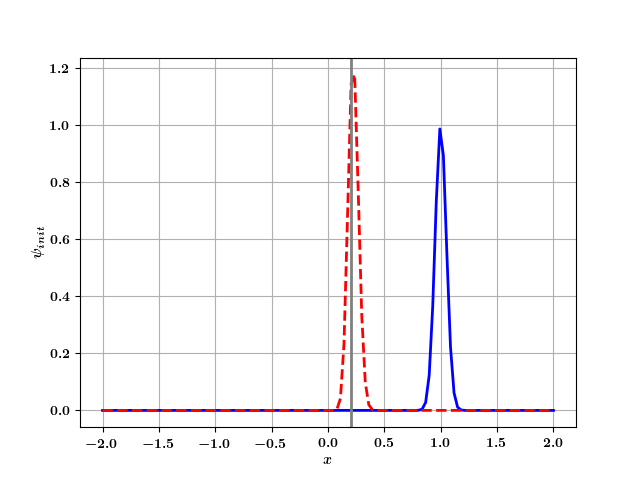

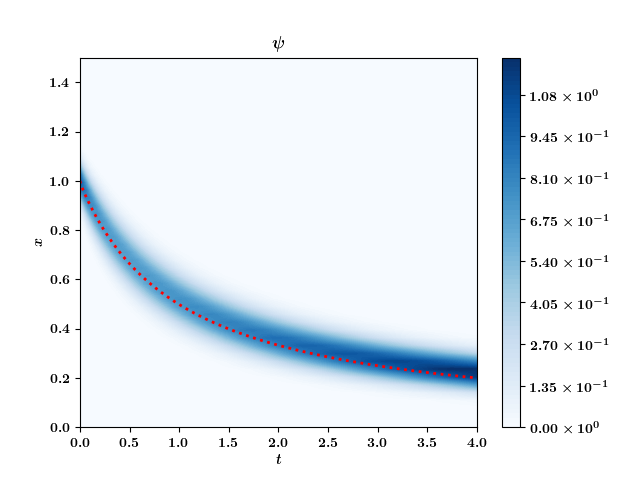

In [30]:
# ---------------------------------------------------------------------------------------------------
# --- Print psi_tx_uw(t,x) ---
# ---------------------------------------------------------------------------------------------------
XX, YY = np.meshgrid(t, x)

plt.close()
fig_tx = plt.figure()
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, np.transpose(psi_tx_uw.real), levels=100, cmap=cmap_two_signs_)
fig_tx.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
ax.plot(t, x_direct, color='r', linewidth = 2, linestyle=':')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$\psi$')
ax.set_ylim(0.0, 1.5)

# ---------------------------------------------------------------------------------------------------
# --- Print psi(x) at different t ---
# ---------------------------------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, psi_tx_uw.real[0,:], color='b', linewidth = 2, linestyle='-')
# ax.plot(x, psi_tx_uw.real[10,:], color='r', linewidth = 2, linestyle='--')
# ax.plot(x, psi_tx_uw.real[40,:], color='r', linewidth = 2, linestyle='--')
# ax.plot(x, psi_tx_uw.real[80,:], color='r', linewidth = 2, linestyle='--')
ax.plot(x, psi_tx_uw.real[-1,:], color='r', linewidth = 2, linestyle='--')
# ax.vlines(x_direct[-1], ax.get_ylim()[0]-1, ax.get_ylim()[1]+1)
ax.axvline(x_direct[-1], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = 'gray', linewidth = 2, linestyle = "-")
plt.xlabel('$x$')
plt.ylabel("$\psi_{init}$")
# ax.legend()
plt.grid(True)
plt.show()